# Task 1: Exploratory analysis and hypothesis driven bioinformatic workflow implementation: Cancer data EDA
# Exploring cancer related variables and prepare data for survival analysis

To better understand the clinical and molecular landscape of colorectal cancer (CRC) within this dataset, I now focus **exclusively on tumor (cancerous) samples** to study theis cariables, clean the data, explore its space, and prepare for survival analysis.


#### Key Cancer-Related Variables to Explore:

- **Mutation data**: `braf_mutation`, `kras_mutation`, `egfr_mutated`, `tp53_mutation`
- **Tumor characteristics**: `stage`, `grade`, `histological_type`, `histological_subtype`, `tumor_type`
- **Molecular classification**: `cms`, `molecular_type`, `msi_status`, `tmb`, `tmb_group`
- **Treatment & response**: `line_of_treatment`, `therapy_type`, `therapy_response`, `prior_treatment`
- **Target**: `os_time`, `os_status`


#### Goals of This Exploration

- Summarize the availability and distribution of cancer-specific variables.
- Identify patterns, subgroups, or correlations that may inform downstream analysis.
- Decide which variables are suitable for **modeling or biological interpretation** and which may need to be excluded due to poor data quality.


In [1]:
# importing libraries
import pandas as pd
import conorm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata
import gseapy as gp
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../scripts')  

import plotting_utils as mplt
from de_gsea import run_pipeline

sys.path.append('../notebooks')  


# # load the data
metadata_df = pd.read_csv('../data/metadata.csv', index_col=0)
expression_df = pd.read_csv('../data/raw_expression.csv', index_col=0)
scaled_expression = pd.read_csv('../data/scaled_log_expression.csv', index_col=0)


In [2]:
cancer_df = metadata_df[(metadata_df['os_status'].notna())& (metadata_df['os_time'].notna())].copy()
cancer_df = cancer_df[cancer_df['biopsy_timepoint'] != 'At event']
expression_df = expression_df.loc[cancer_df.index]
scaled_filtered = scaled_expression.loc[cancer_df.index]
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, TCGA-3L-AA1B-01A-11R-A37K-07 to TCGA-G5-6641-01A-11R-A32Z-07
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   628 non-null    float64
 1   biopsy_subsite        462 non-null    object 
 2   braf_mutation         514 non-null    object 
 3   biopsy_site           628 non-null    object 
 4   biopsy_timepoint      628 non-null    object 
 5   cms                   578 non-null    object 
 6   distal_vs_proximal    617 non-null    object 
 7   egfr_mutated          514 non-null    object 
 8   grade                 0 non-null      object 
 9   histological_subtype  628 non-null    object 
 10  histological_type     628 non-null    object 
 11  kras_mutation         514 non-null    object 
 12  msi_status            613 non-null    object 
 13  molecular_type        236 non-null    object 
 14  os_status             628 n

In [3]:
# dropping irrelevant columns 
cancer_df = cancer_df.drop(['pfs_status', 'pfs_time', 'sample_type','biopsy_timepoint','data_source','therapy_response','grade'], axis = 1)

### Reusable function for visualization of cancer metadata

- Categorical frequency barplots
- Numerical features histograms
- PCA, T-SNE, and UMAP 

### Mutation Status Summary

In the colorectal cancer samples analyzed, the majority of cases for **EGFR**, **BRAF**, and **KRAS** are of the **wild-type** category, with relatively few **mutated** cases observed. Notably, **TP53** is the only gene where **mutated** status is more prevalent than wild type.

However, across all four genes (**EGFR**, **BRAF**, **KRAS**, and **TP53**), a low proportion of data around **18%**—is missing, will be imputed based on expression profiles.


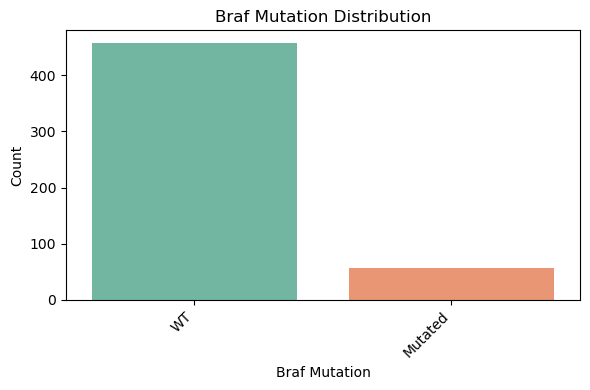

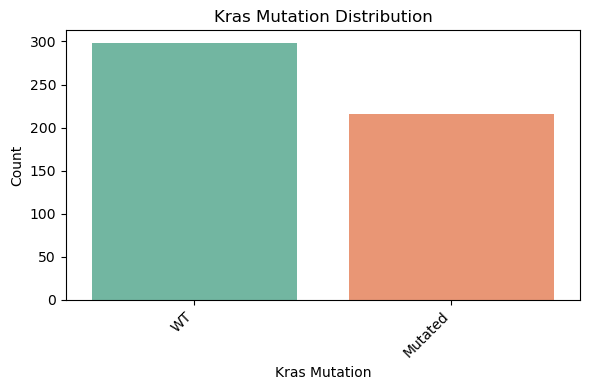

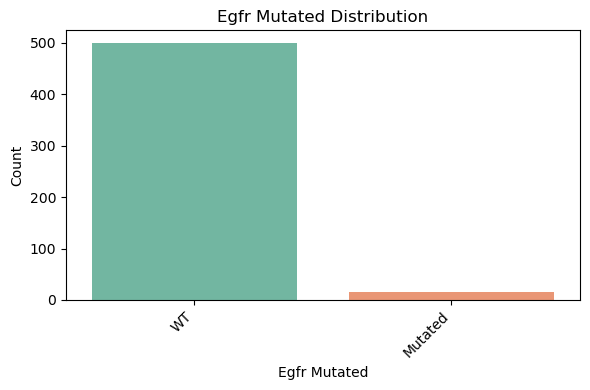

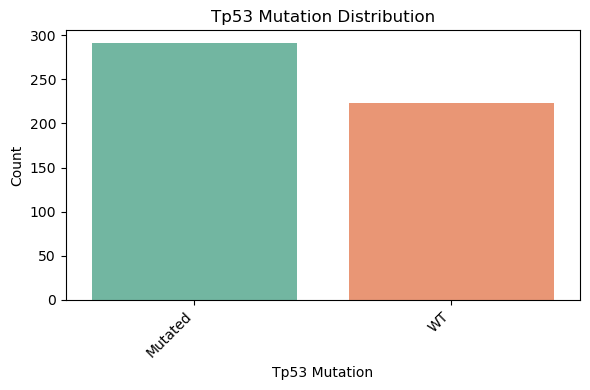

In [4]:
# Mutation columns to explore
mutation_cols = ['braf_mutation', 'kras_mutation', 'egfr_mutated', 'tp53_mutation']
mplt.plot_categorical_distributions(cancer_df, mutation_cols)


## 🧬 Tumor Characteristic Distributions (Non-Missing)

The figure shows the distributions of key tumor characteristics among colorectal cancer samples labeled as **Primary cancer**, excluding missing values:

- **Stage**: The majority of samples are in **stage III** and **stage II**, with fewer cases in stages IV and I.
- **Grade**: The distribution is limited and skewed due to significant missing data (see note below).
- **Histological Type**: Most samples fall under the categories **"Neoplasm"** and **"Adenomas and adenocarcinomas"**.
- **Histological Subtype**: Dominated by **"Adenocarcinoma"** and **"Malignant tumor"**, followed by a long tail of less frequent subtypes.



### 📌 Data Quality and Missingness

- **Grade** has **96% missing values** and contributes minimal usable information.  
  👉 **Action**: This variable will be **dropped** from further analysis.

- **Stage** has **~57% missing values**, which is considerable.  
  👉 **Action**:  Using only complete cases for exploratory plots.

- **Histological Type** and **Histological Subtype** have **no missing data** and are informative.  
  👉 **Action**: These variables will be **retained** and may be considered for stratification or inclusion in predictive models. Very low classes in count will be merged, this can be done based on domain knowledge, I will do it based on count only for simplicity





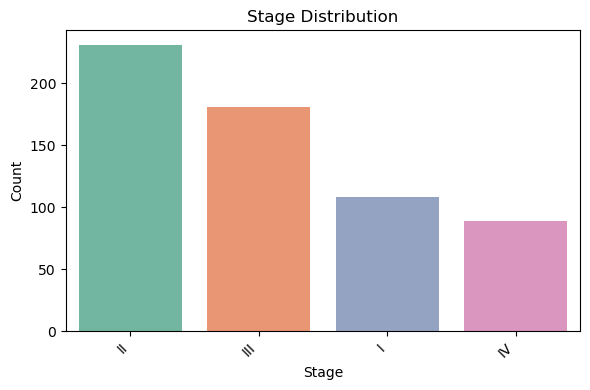

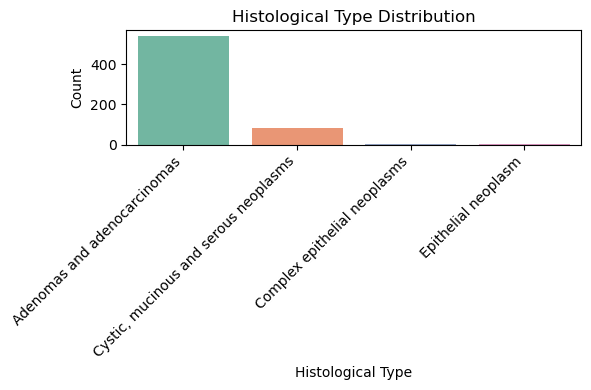

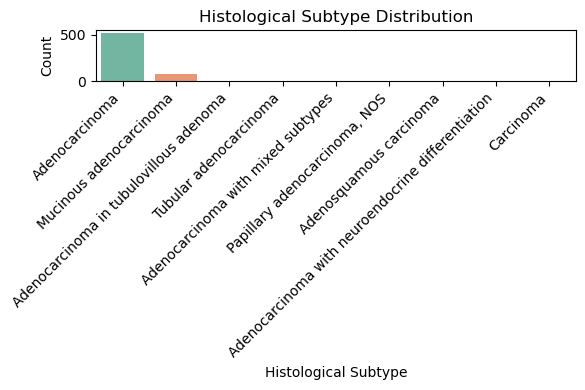

In [5]:
# Tumor characteristic columns to explore
tumor_cols = ['stage','histological_type', 'histological_subtype']
mplt.plot_categorical_distributions(cancer_df, tumor_cols)


In [6]:
# Merge rare subtypes into 'Other'
subtype_counts = cancer_df['histological_subtype'].value_counts()
rare_subtypes = subtype_counts[subtype_counts < 10].index

cancer_df['histological_subtype'] = cancer_df['histological_subtype'].replace(rare_subtypes, 'Other')


# Merge rare types into 'Other'
subtype_counts = metadata_df['histological_type'].value_counts()
rare_subtypes = subtype_counts[subtype_counts < 50].index

cancer_df['histological_type'] = cancer_df['histological_type'].replace(rare_subtypes, 'Other')


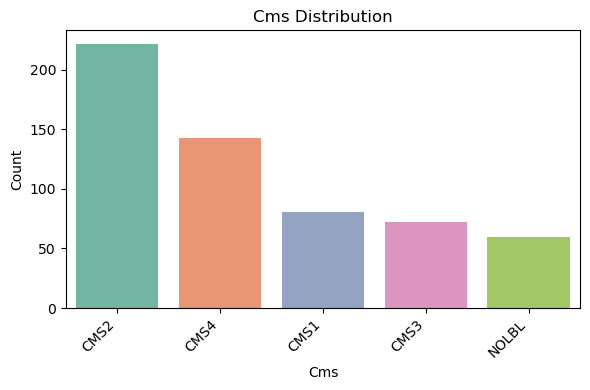

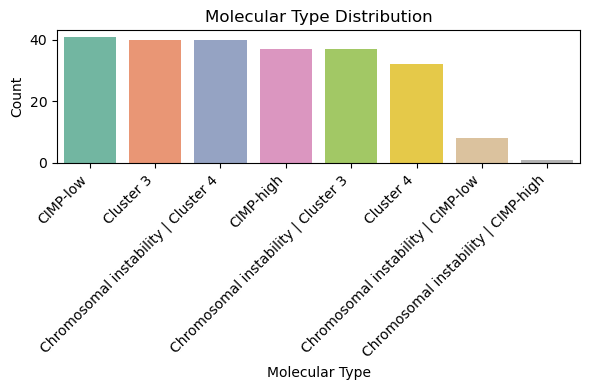

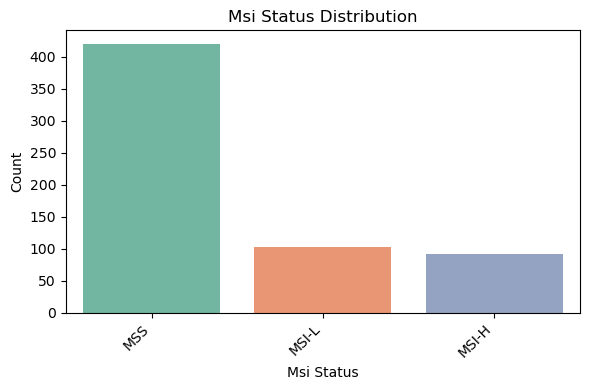

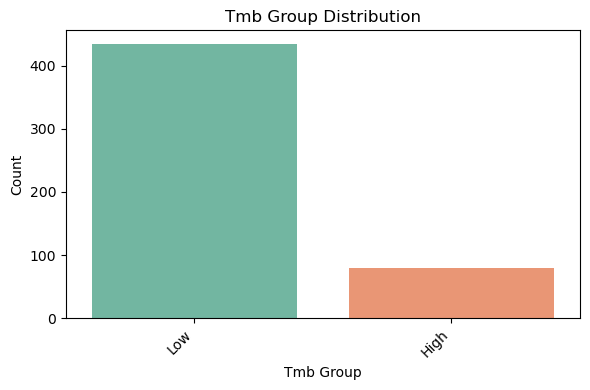

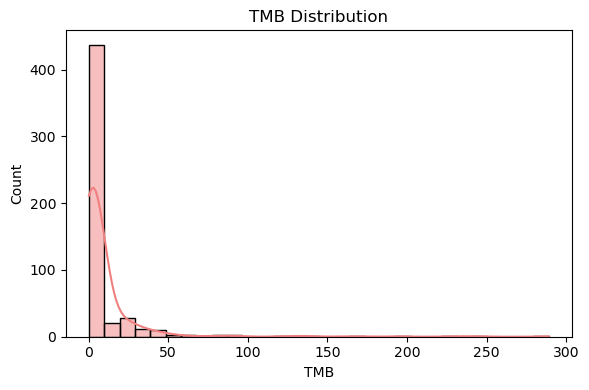

In [7]:
# Molecular classification columns
molecular_categorical = ['cms', 'molecular_type', 'msi_status', 'tmb_group']
molecular_continuous = ['tmb']
mplt.plot_categorical_distributions(cancer_df, molecular_categorical)
mplt.plot_continuous_distributions(cancer_df, molecular_continuous)


In [8]:
cancer_df['molecular_type'].unique()

array([nan, 'CIMP-high', 'Cluster 4',
       'Chromosomal instability | Cluster 3', 'Cluster 3',
       'Chromosomal instability | CIMP-low',
       'Chromosomal instability | Cluster 4', 'CIMP-low',
       'Chromosomal instability | CIMP-high'], dtype=object)

In [9]:

# Function to split based on known categories
# Function to extract each category type
def extract_types(val):
    if pd.isna(val):
        return pd.Series([np.nan, np.nan, np.nan])
    
    cluster = np.nan
    cimp = np.nan
    instability = np.nan
    
    if "Cluster" in val:
        cluster = [x for x in val.split(" | ") if "Cluster" in x][0]
    if "CIMP" in val:
        cimp = [x for x in val.split(" | ") if "CIMP" in x][0]
    if "Chromosomal instability" in val:
        instability = 1
    else:
        instability = 0
    
    
    return pd.Series([cluster, cimp, instability])

# Apply function to create new columns

cancer_df[['cluster', 'cimp', 'instability']] =cancer_df['molecular_type'].apply(extract_types)
cancer_df= cancer_df.drop(columns='molecular_type')

In [10]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, TCGA-3L-AA1B-01A-11R-A37K-07 to TCGA-G5-6641-01A-11R-A32Z-07
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   628 non-null    float64
 1   biopsy_subsite        462 non-null    object 
 2   braf_mutation         514 non-null    object 
 3   biopsy_site           628 non-null    object 
 4   cms                   578 non-null    object 
 5   distal_vs_proximal    617 non-null    object 
 6   egfr_mutated          514 non-null    object 
 7   histological_subtype  628 non-null    object 
 8   histological_type     628 non-null    object 
 9   kras_mutation         514 non-null    object 
 10  msi_status            613 non-null    object 
 11  os_status             628 non-null    object 
 12  os_time               628 non-null    float64
 13  primary_site          628 non-null    object 
 14  prior_treatment       628 n

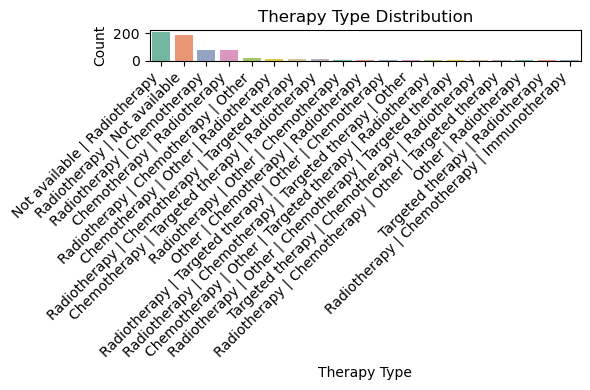

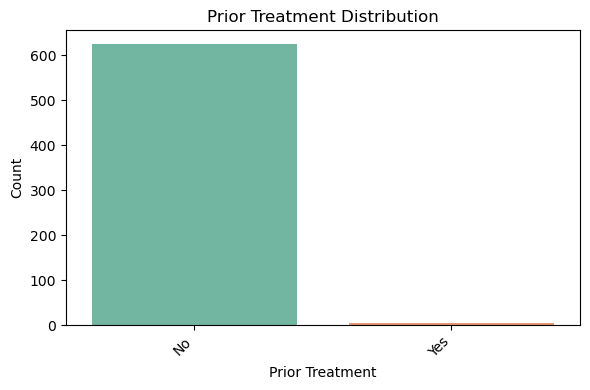

In [11]:
# Define our new column groups
treatment_categorical = ['therapy_type', 'prior_treatment']
survival_continuous = ['os_time']

mplt.plot_categorical_distributions(cancer_df, treatment_categorical)




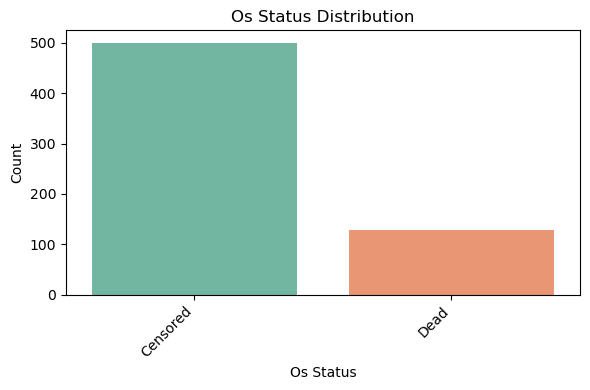

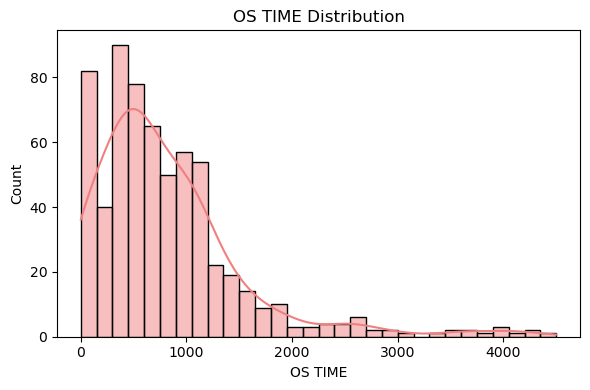

In [12]:
survival_categorical = ['os_status']  
mplt.plot_categorical_distributions(cancer_df, survival_categorical)
mplt. plot_continuous_distributions(cancer_df, survival_continuous)

In [13]:
def extract_first_line(s):
    if '|' not in s:
        return s
    return s.split('|')[0].strip()

def extract_second_line(s):
    if '|' not in s:
        return 'No second line'
    parts = s.split('|')
    if len(parts) > 1:
        return parts[1].strip()

def has_more_than_two_steps(s):
    if '|' not in s:
        return 0
    return int(s.count('|') > 1)

# Apply the new functions
cancer_df['first_line_treatment'] = cancer_df['therapy_type'].apply(extract_first_line)
cancer_df['second_line_treatment'] = cancer_df['therapy_type'].apply(extract_second_line)
cancer_df['has_further_steps'] = cancer_df['therapy_type'].apply(has_more_than_two_steps)
cancer_df['os_time'] = cancer_df['os_time']


# Drop the original 'therapy_type' column if needed
cancer_df = cancer_df.drop(columns=['therapy_type', 'tmb', 'prior_treatment'])

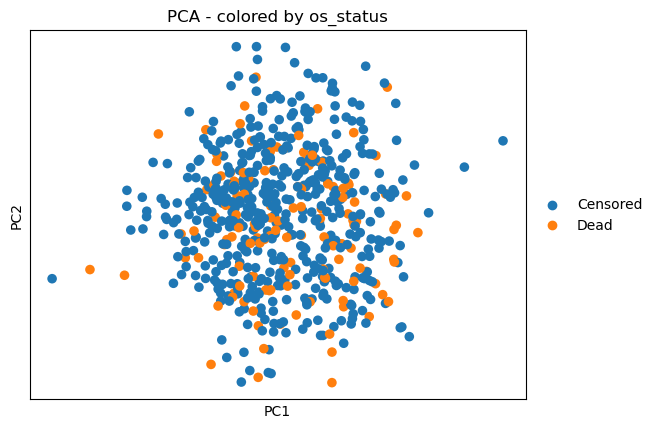

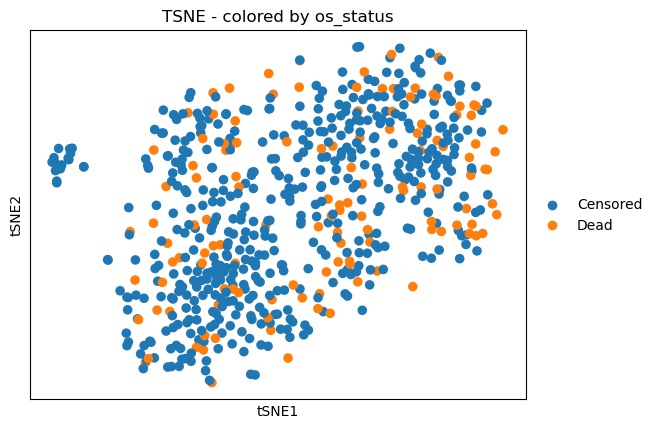

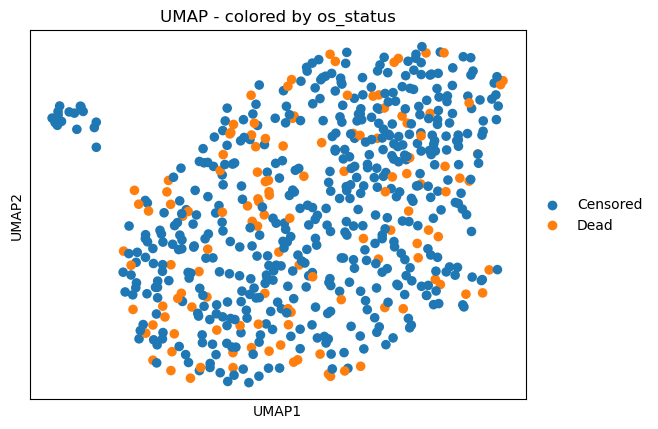

In [14]:
# TMM normalization
expression_df = expression_df.transpose()
expression_tmm = conorm.tmm(expression_df)
# Log scaling
log_tmm = np.log2(expression_tmm + 1)

# Keep genes expressed in at least 10% of the samples
min_samples = log_tmm.shape[1]//5
filtered_expr = log_tmm.loc[(log_tmm > 1).sum(axis=1) > min_samples,:].transpose()
cancer_adata = anndata.AnnData(filtered_expr.loc[filtered_expr.index.intersection(cancer_df.index)])


# Add all columns from metadata_df to adata.obs
for col in cancer_df.columns:
    cancer_adata.obs[col] = cancer_df[col]

# # Select Highly Variable Genes 
sc.pp.highly_variable_genes(cancer_adata, flavor='seurat', n_top_genes=300)
cancer_adata = cancer_adata[:, cancer_adata.var['highly_variable']]

# Scale data (z-score genes)
sc.pp.scale(cancer_adata)

# PCA
sc.tl.pca(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

#plotting by biopsy site
mplt.plot_reductions(cancer_adata, 'os_status')

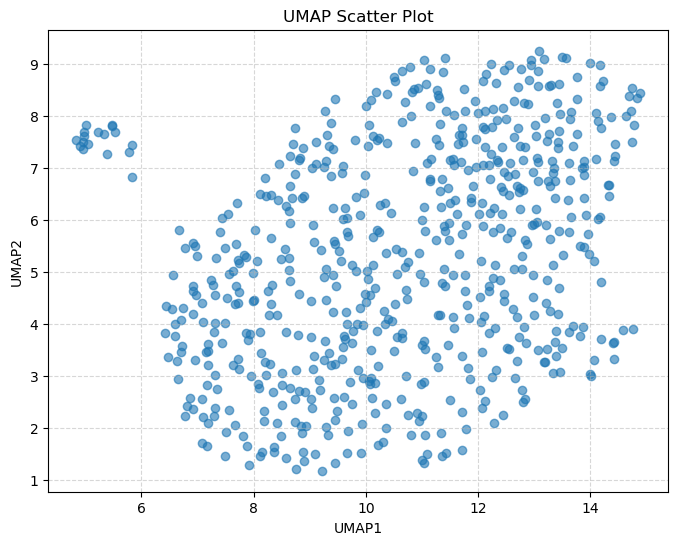

In [15]:
# Extract UMAP coordinates
umap1 = cancer_adata.obsm['X_umap'][:, 0]
umap2 = cancer_adata.obsm['X_umap'][:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(umap1, umap2, alpha=0.6)

# Correct axis labels
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP Scatter Plot")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [16]:
# Extract PC2 scores 
umap1_scores = cancer_adata.obsm['X_umap'][:, 0]

# Define outlier threshold (example: abs(umap) > 5)
threshold = 6
mask = np.abs(umap1_scores) > threshold

# Filter AnnData to keep only samples within threshold
cancer_adata = cancer_adata[mask, :].copy()
# cancer_df = cancer_df.loc[mask]
# expression_df = expression_df.transpose().loc[cancer_df.index]
# scaled_filtered = scaled_filtered.loc[cancer_df.index]

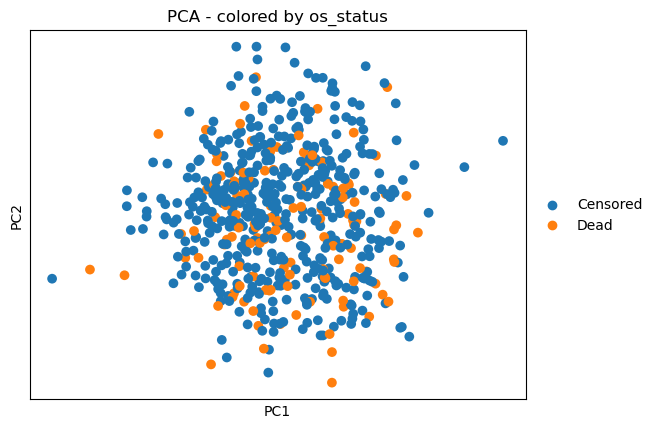

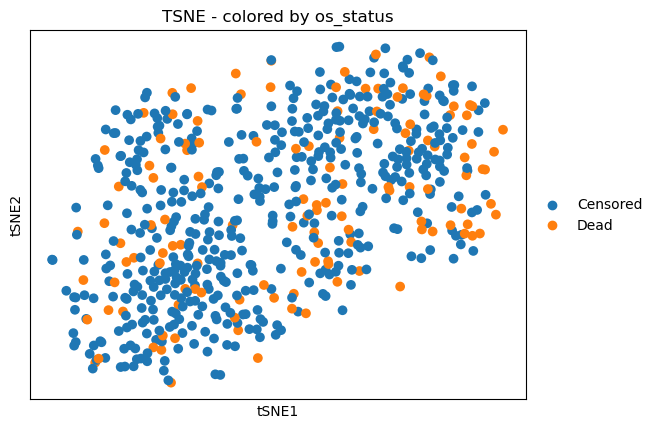

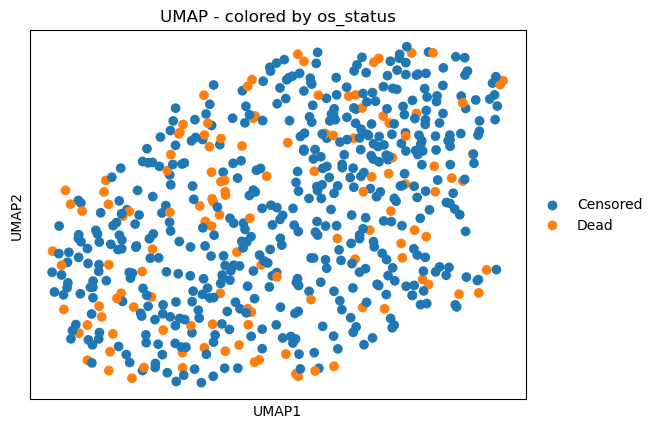

In [17]:
mplt.plot_reductions(cancer_adata, 'os_status')

In [18]:
# Filter cancer_df for known gender and age
filtered_cancer_df = cancer_df.dropna(subset=['gender', 'age'])

# Get the valid sample IDs/indexes
valid_samples = filtered_cancer_df.index

# Subset expression_df: keep only columns/samples in valid_samples
filtered_expression_df = expression_df.loc[:, expression_df.columns.isin(valid_samples)]

# Subset scaled_filtered similarly
filtered_scaled_filtered = scaled_filtered.loc[scaled_filtered.index.isin(valid_samples)]

# Now run the pipeline with filtered datasets
run_pipeline(
    filtered_expression_df.transpose(),  # transpose if your function expects samples as rows
    filtered_cancer_df,
    filtered_scaled_filtered,
    ['os_status', 'age', 'gender'],
    ('os_status', 'Censored', 'Dead'),
    '../results/cancer_gsea',
    '../data/hallmarks.gmt'
)


🔹 Running DESeq2...


Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.27 seconds.

/home/fatouh/anaconda3/envs/epigene_crc_env/lib/python3.12/site-packages/pydeseq2/utils.py:380: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/fatouh/anaconda3/envs/epigene_crc_env/lib/python3.12/site-packages/pydeseq2/utils.py:234: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/fatouh/anaconda3/envs/epigene_crc_env/lib/python3.12/site-packages/pydeseq2/utils.py:232: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/fatouh/anaconda3/envs/epigene_crc_env/lib/python3.12/site-packages/pydeseq2/utils.py:384: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/fatouh/anaconda3/envs/epigene_crc_env/lib/python3.12/site-packages/pydeseq2/utils.py:387: RuntimeWarning: invalid value encountered in divide
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/fatouh/anaconda3/envs/epigen

Log2 fold change & Wald test p-value: os_status Censored vs Dead
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG          1.438802        0.018710  0.171422  0.109148  0.913085  0.965582
A1BG-AS1      8.184489        0.024672  0.115015  0.214511  0.830148  0.929857
A1CF        732.397732       -0.000056  0.112080 -0.000497  0.999604  0.999810
A2M       12060.929987       -0.082582  0.100661 -0.820395  0.411991  0.684050
A2M-AS1      15.775423        0.079341  0.113616  0.698331  0.484970  0.737989
...                ...             ...       ...       ...       ...       ...
ZYG11A        3.780008       -0.009473  0.192935 -0.049100  0.960840  0.985359
ZYG11B      896.188891        0.139864  0.063248  2.211364  0.027011  0.166508
ZYX        7274.012471       -0.043105  0.072688 -0.593013  0.553173  0.780803
ZZEF1      2122.346024        0.119545  0.064056  1.866249  0.062007  0.264436
ZZZ3       1229.010499        0.114062  0.051273  2.224587  0.0261

In [19]:
pre_res= pd.read_csv('../results/cancer_gsea/gsea_results/gsea_summary.csv')
significant_sets = pre_res[pre_res['FDR q-val'] < 0.25]
# Flatten all genes split by ';' into a list
all_genes = [g for gene_str in significant_sets['Lead_genes'] for g in gene_str.split(';')]

# Get unique genes
unique_genes = list(set(all_genes))

# Filter expression DataFrame columns by these genes
scaled_df_filtered = scaled_filtered.loc[:, scaled_filtered.columns.isin(unique_genes)]

scaled_df_filtered.shape

(628, 2600)

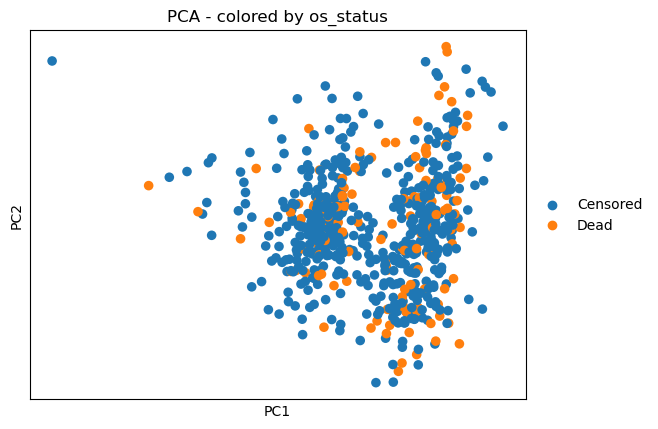

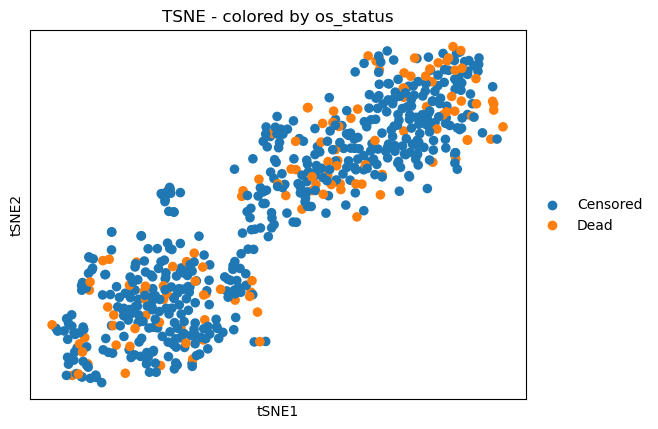

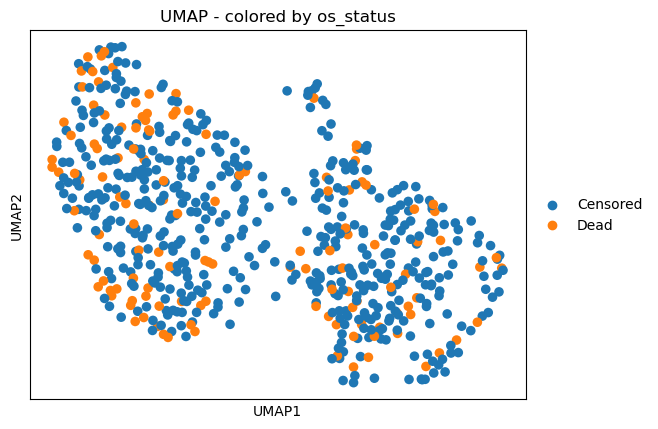

In [20]:
cancer_adata = anndata.AnnData(scaled_df_filtered)


# Add all columns from metadata_df to adata.obs
for col in cancer_df.columns:
    cancer_adata.obs[col] = cancer_df[col]


# Scale data (z-score genes)
sc.pp.scale(cancer_adata)

# PCA
sc.tl.pca(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

#plotting by biopsy site
mplt.plot_reductions(cancer_adata, 'os_status')

leiden
0    345
1    283
Name: count, dtype: int64


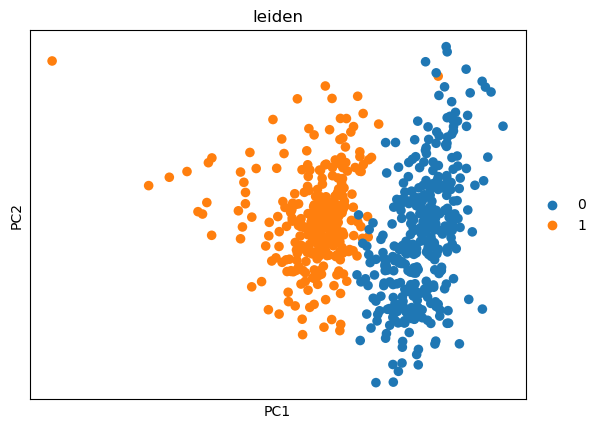

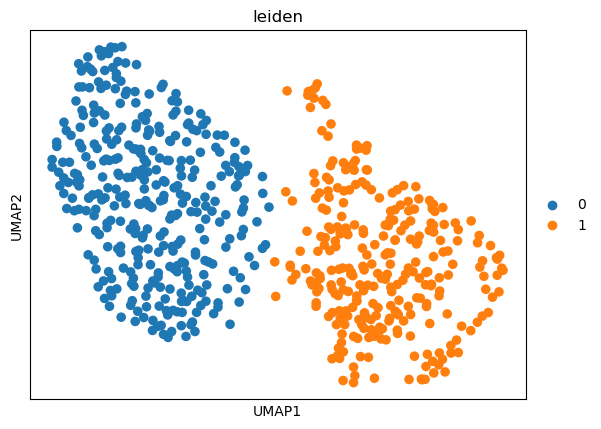

In [21]:
sc.pp.neighbors(cancer_adata, use_rep='X_umap') 
sc.tl.leiden(cancer_adata, resolution=0.05)     

# Add Leiden clusters to metadata
print(cancer_adata.obs['leiden'].value_counts())
# Plot PCA with Leiden clusters
sc.pl.pca(cancer_adata, color=['leiden'])
# Plot UMAP with Leiden clusters
sc.pl.umap(cancer_adata, color=['leiden'])

In [22]:

if 'leiden' in cancer_adata.obs.columns:
    ref = cancer_adata.obs['leiden'].astype(str).values
    scores = {}
    for col in cancer_adata.obs.columns:
        vals = cancer_adata.obs[col].astype(str).values
        try:
            scores[col] = adjusted_rand_score(ref, vals)
        except Exception:
            scores[col] = np.nan
    # rank columns by similarity to 'leiden'
    print(sorted(scores.items(), key=lambda x: - (x[1] if x[1] is not None else -1))[:10])
print(scores)

[('leiden', 1.0), ('instability', 0.5301025160069802), ('cluster', 0.25272128454068926), ('cimp', 0.10190916835828624), ('cms', 0.006875644519972692), ('second_line_treatment', 0.004029492736298166), ('histological_type', 0.003996592618252472), ('tp53_mutation', 0.00265192826287819), ('os_time', 0.0022642885954981323), ('biopsy_subsite', 0.0012734814223521376)]
{'age': -0.0004215686040410855, 'biopsy_subsite': 0.0012734814223521376, 'braf_mutation': -0.0030069504027113664, 'biopsy_site': -0.0017000845469746142, 'cms': 0.006875644519972692, 'distal_vs_proximal': -0.00033389788327699895, 'egfr_mutated': -7.419211628493646e-05, 'histological_subtype': -0.0032180072605619637, 'histological_type': 0.003996592618252472, 'kras_mutation': -0.0027138490843447768, 'msi_status': -0.001970910066105177, 'os_status': -0.004373373258041535, 'os_time': 0.0022642885954981323, 'primary_site': -0.0017000845469746142, 'gender': 0.00091570220975995, 'stage': -0.00047150266816370747, 'tmb_group': -0.0019293

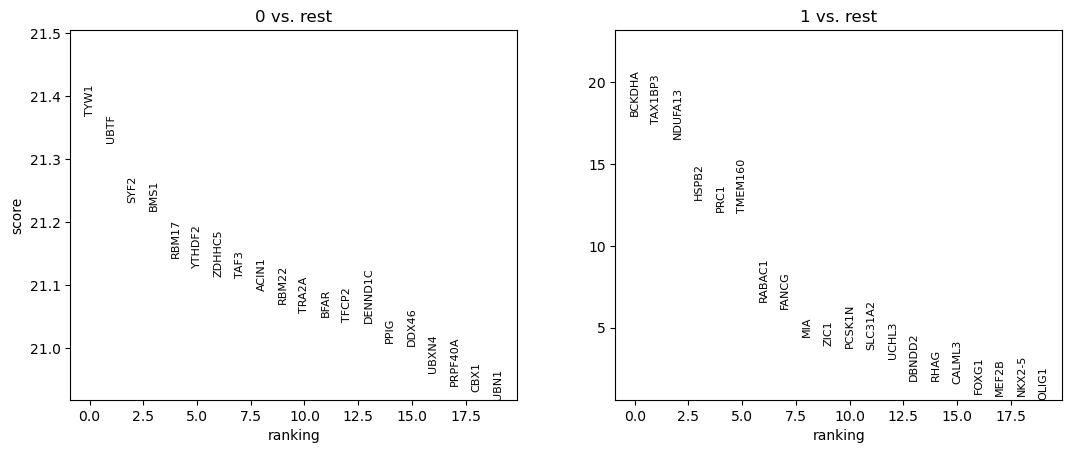

In [23]:
sc.tl.rank_genes_groups(cancer_adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(cancer_adata, n_genes=20, sharey=False)

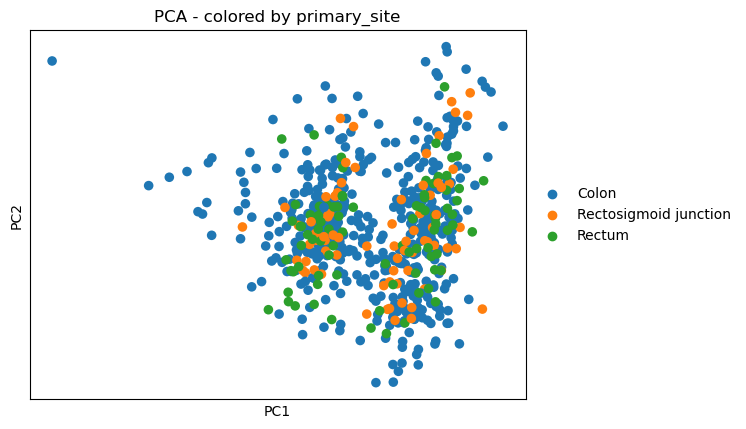

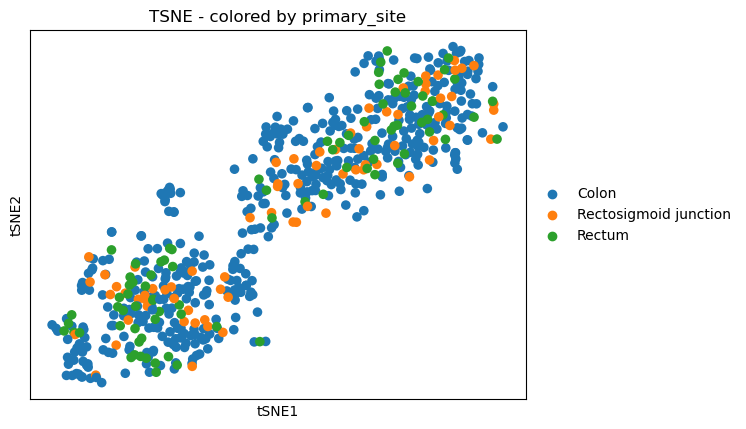

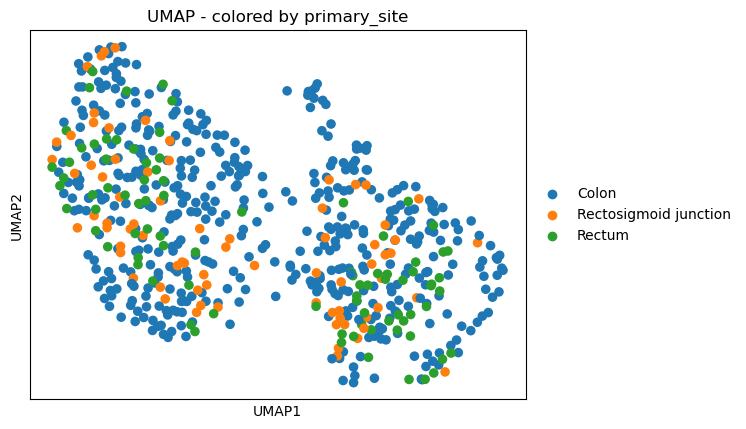

In [24]:
mplt.plot_reductions(cancer_adata, 'primary_site',save_dir='../results/cancer_survival')

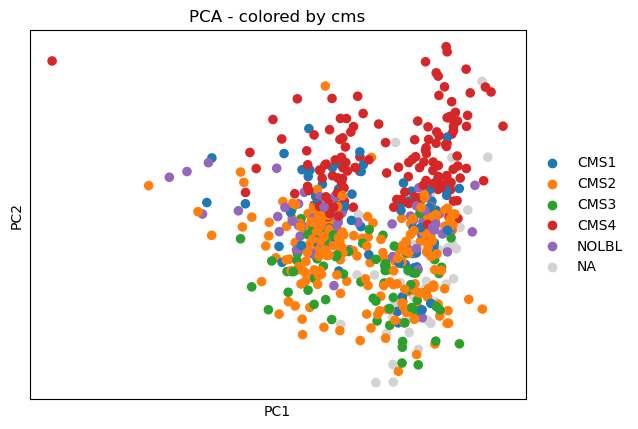

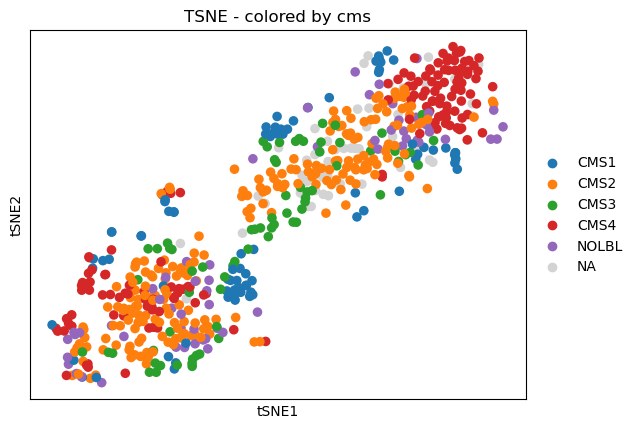

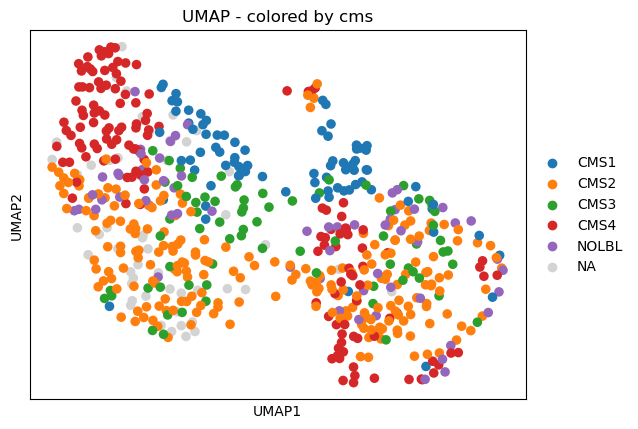

In [25]:
#plotting by biopsy site
mplt.plot_reductions(cancer_adata, 'cms')

In [26]:
cancer_df= cancer_df.drop(columns=['cluster', 'cimp', 'instability'])

In [27]:
filtered_expr = filtered_expr.loc[cancer_df.index]
pre_res= pd.read_csv('../results/cancer_gsea/gsea_results/gsea_summary.csv')
significant_sets = pre_res[pre_res['FDR q-val'] < 0.25]
# Flatten all genes split by ';' into a list
all_genes = [g for gene_str in significant_sets['Lead_genes'] for g in gene_str.split(';')]

# Get unique genes
unique_genes = list(set(all_genes))

# Filter expression DataFrame columns by these genes
filtered_expr =  filtered_expr.loc[:, filtered_expr.columns.isin(unique_genes)]


In [28]:
# save cancer metadats
cancer_df.to_csv('../data/cancer_metadata.csv')
# Save as CSV
filtered_expr.to_csv('../data/cancer_tmm_log.csv')
